# Compare approximate sales of several Japanese mobile games 
Data crawled from game-i.daa

In [1]:
import requests
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
plt.style.use('seaborn')
rc('font',**{'family':'sans-serif','sans-serif':['Source Han Sans JP']})
rc('text', usetex=False)

In [3]:
games = ['ラブライブ！スクールアイドルフェスティバル', 
         'バンドリ！+ガールズバンドパーティ！', 
         'アイドルマスター+シンデレラガールズ+スターライトス...', 
         'ラブライブ！スクールアイドルフェスティバルALL+STARS']
game_english_names = ['SIF', 'Bandori', 'iM@S CG', 'SIFAS']
game_name_map = {games[i]: game_english_names[i] for i in range(len(games))}

In [4]:
base_url = 'https://game-i.daa.jp/?アプリ/'

In [5]:
def download_data(game):
    # Get data from internet
    url = base_url + game
    res = requests.get(url)
    tables = pd.read_html(res.text)
    
    # Get 2 most recent years
    tbl = pd.concat([tables[2], tables[3]])
    # Rename japanese columns and sort by month
    tbl.columns = ['month', 'sales', 'ranking']
    tbl.sort_values('month', inplace=True)
    # Remove unneccessary information
    tbl.drop((tbl[tbl.month == '合計']).index, inplace=True)
    tbl.reset_index(inplace=True, drop=True)
    tbl.drop(columns=['ranking'], inplace=True)
    
    # Shorten date
    for index, row in tbl.iterrows():
        row['month'] = row['month'].replace('20', '', 1)

        # Convert japanese numbers to decimal
        if row['sales'] == None:
            continue

        row['sales'] = row['sales'].strip('G')
        if row['sales'] == '未':
            row['sales'] = None
            continue

        if row['sales'].endswith('億'):
            row['sales'] = float(row['sales'].strip('億').replace(',', ''))
        elif row['sales'].endswith('万'):
            row['sales'] = float(row['sales'].strip('万').replace(',', '')) / 10000
    
    tbl.rename({'sales': 'sales_' + game_name_map[game]}, axis=1, inplace=True)
    
    return tbl

In [8]:
game_tables = [download_data(game) for game in tqdm(games)]



  0%|                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████▌                                     | 1/4 [00:00<00:01,  1.74it/s]

 50%|█████████████████████████                         | 2/4 [00:01<00:01,  1.64it/s]

 75%|█████████████████████████████████████▌            | 3/4 [00:01<00:00,  1.65it/s]

100%|██████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


In [9]:
games_df = pd.concat(game_tables, axis=1)

In [10]:
# Remove duplicated "month" columns and null rows
games_df = games_df.loc[:, ~games_df.columns.duplicated()]
games_df.dropna(inplace=True)

In [11]:
games_df.head()

,month,sales_SIF,sales_Bandori,sales_iM@S CG,sales_SIFAS
0,20/01,1.62,5.57,7.91,4.72
1,20/02,1.0,4.8,5.65,4.03
2,20/03,1.16,13.36,17.37,4.41
3,20/04,2.29,4.63,5.94,3.5
4,20/05,1.64,4.87,7.79,3.45


In [12]:
plot_cols = [col for col in games_df.columns if 'sales' in col]

In [13]:
xticks = range(len(games_df['month']))
xticks_labels = [games_df['month'][i] if i % 3 == 0 else '' for i in range(len(games_df['month']))]

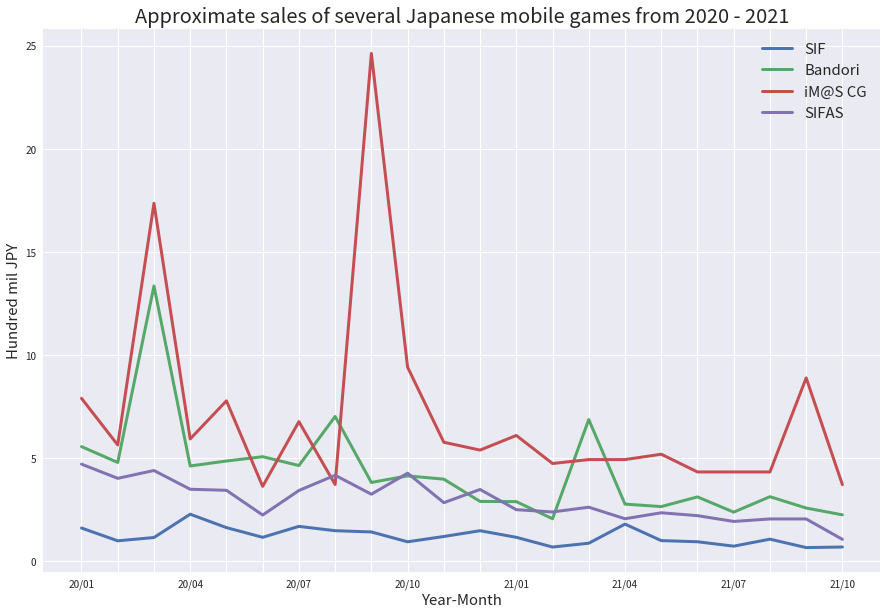

  0%|                                                          | 0/4 [01:41<?, ?it/s]

In [14]:
ax: plt.Axes = games_df.plot(
    kind='line', 
    x='month', 
    y=plot_cols, 
    figsize=(15, 10), 
    lw=3)
ax.set_title('Approximate sales of several Japanese mobile games from 2020 - 2021', {'fontsize': 20})
ax.set_xlabel('Year-Month', fontdict={'size': 15})
ax.set_ylabel('Hundred mil JPY', fontdict={'size': 15})
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels)
ax.legend([col.replace('sales_', '') for col in plot_cols], prop={'size': 15})